In [1]:
# Import required libraries
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,roc_curve, auc

In [2]:
df = pd.read_csv("synthetic_river_health_data.csv")
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (10000, 11)
             Timestamp                            Factory_ID    Industry_Type  \
0  2023-01-01 00:00:00  2d3ff23d-752b-4a7a-9e4a-1e1ca9e1459a          textile   
1  2023-01-01 01:00:00  0beb08f9-56cd-4e37-be8e-ae4ce8d57f01         chemical   
2  2023-01-01 02:00:00  39831a98-458d-4259-a17c-1a7232b2c61e  food_processing   
3  2023-01-01 03:00:00  0beb08f9-56cd-4e37-be8e-ae4ce8d57f01  food_processing   
4  2023-01-01 04:00:00  39831a98-458d-4259-a17c-1a7232b2c61e  food_processing   

     pH  Turbidity  Dissolved_Oxygen  Water_Temperature  Conductivity  \
0  7.48      20.33              6.93                NaN        482.16   
1  5.57        NaN              7.42              15.34        315.82   
2  6.79       6.46              9.06              13.04         61.03   
3  7.08       4.07              9.30              11.12           NaN   
4  6.80       3.15               NaN              12.77        159.92   

   Nitrate  Water_Quality_Index  Pollution_Flag

In [3]:
# Display basic information about the dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            10000 non-null  object 
 1   Factory_ID           10000 non-null  object 
 2   Industry_Type        10000 non-null  object 
 3   pH                   9273 non-null   float64
 4   Turbidity            9309 non-null   float64
 5   Dissolved_Oxygen     9307 non-null   float64
 6   Water_Temperature    9272 non-null   float64
 7   Conductivity         9331 non-null   float64
 8   Nitrate              9352 non-null   float64
 9   Water_Quality_Index  6951 non-null   float64
 10  Pollution_Flag       10000 non-null  int64  
dtypes: float64(7), int64(1), object(3)
memory usage: 859.5+ KB


In [4]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Timestamp                 0
Factory_ID                0
Industry_Type             0
pH                      727
Turbidity               691
Dissolved_Oxygen        693
Water_Temperature       728
Conductivity            669
Nitrate                 648
Water_Quality_Index    3049
Pollution_Flag            0
dtype: int64


In [6]:
# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [7]:
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['hour'] = df['Timestamp'].dt.hour
df['is_weekend'] = df['Timestamp'].dt.weekday.isin([5, 6]).astype(int)

In [8]:
# Handle missing values
impute_cols = ['pH', 'Nitrate', 'Water_Temperature', 'Turbidity', 'Dissolved_Oxygen', 'Conductivity']
for col in impute_cols:
    df[col] = df.groupby('Industry_Type')[col].transform(
        lambda x: x.fillna(x.median())
    )

In [9]:
# Create binary flags for concerning levels based on the newly included/renamed columns
df['high_nitrate'] = (df['Nitrate'] > 50).astype(int)
df['acidic_ph'] = (df['pH'] < 6.0).astype(int)
df['high_water_temp'] = (df['Water_Temperature'] > 25.0).astype(int)
df['high_turbidity'] = (df['Turbidity'] > 50.0).astype(int)
df['low_do'] = (df['Dissolved_Oxygen'] < 5.0).astype(int)

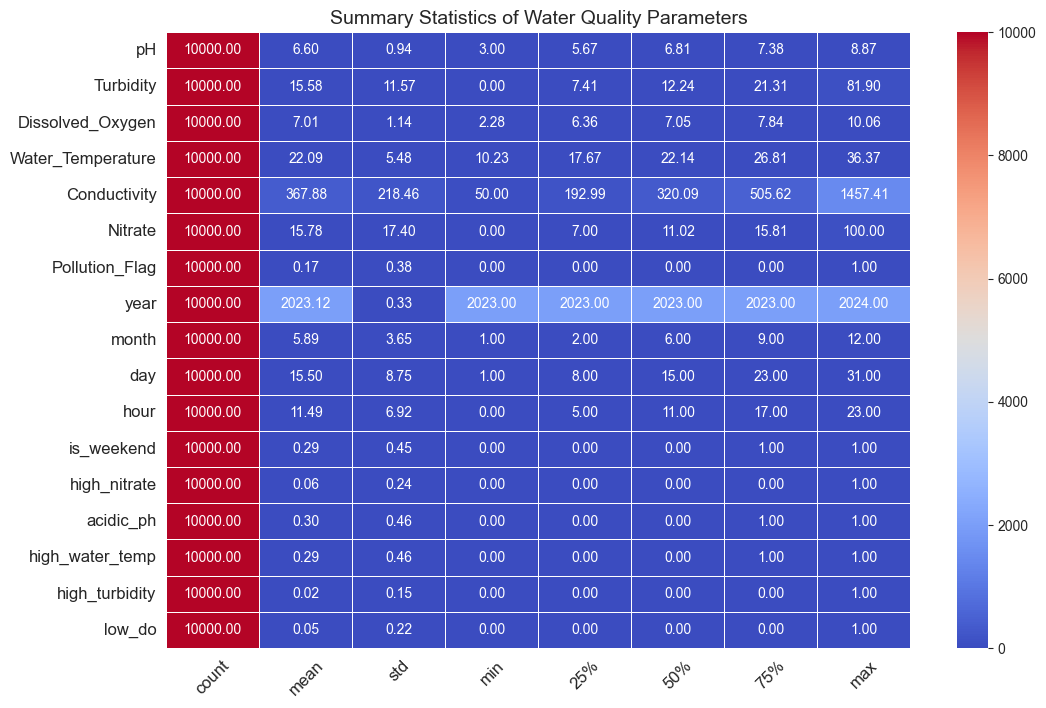

In [10]:
# Display summary statistics
# Remove non-numeric columns and WQI before computing statistics
df_numeric = df.select_dtypes(include=['number']).drop(columns=['Factory_ID', 'Water_Quality_Index'], errors='ignore')

# Compute summary statistics
summary_stats = df_numeric.describe().T

# Set seaborn style
sns.set_style("whitegrid")

# Plot Summary Statistics
plt.figure(figsize=(12, 8))
sns.heatmap(summary_stats, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)

# Titles and labels
plt.title("Summary Statistics of Water Quality Parameters", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [11]:
# Check distribution of measurements by industry
print("\nMeasurements by Industry:")
print(df['Industry_Type'].value_counts())


Measurements by Industry:
Industry_Type
textile            3360
food_processing    3336
chemical           3304
Name: count, dtype: int64


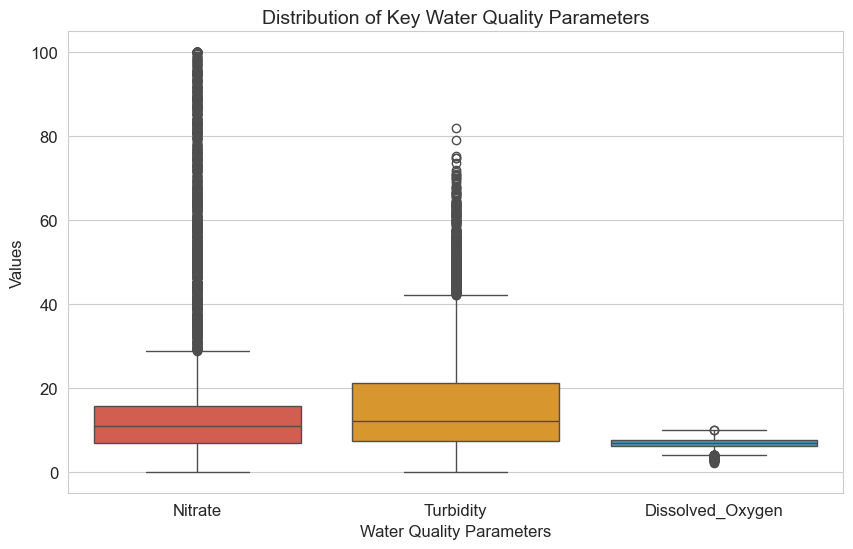

In [12]:
# Plot boxplots for key water quality parameters
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
# Plot boxplots for Nitrate, Turbidity, and Dissolved_Oxygen
sns.boxplot(data=df[['Nitrate', 'Turbidity', 'Dissolved_Oxygen']], palette=["#e74c3c", "#f39c12", "#3498db"])
plt.title("Distribution of Key Water Quality Parameters", fontsize=14)
plt.xlabel("Water Quality Parameters", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Dataset Correlation Matrix (Updated Features):
                         pH  Turbidity  Dissolved_Oxygen  Water_Temperature  \
pH                 1.000000   0.181547          0.010126           0.302797   
Turbidity          0.181547   1.000000         -0.650392           0.467858   
Dissolved_Oxygen   0.010126  -0.650392          1.000000          -0.593279   
Water_Temperature  0.302797   0.467858         -0.593279           1.000000   
Conductivity       0.201185   0.796505         -0.670149           0.552413   
Nitrate           -0.336789   0.557033         -0.559344           0.085362   
Pollution_Flag    -0.072793   0.526478         -0.436149          -0.009058   
year               0.013822   0.013125          0.125077          -0.278506   
month             -0.005994   0.007613         -0.264248           0.226232   
day               -0.010987  -0.015405         -0.007081           0.023043   
hour              -0.000321   0.001705          0.003240           0.006798   
is_w

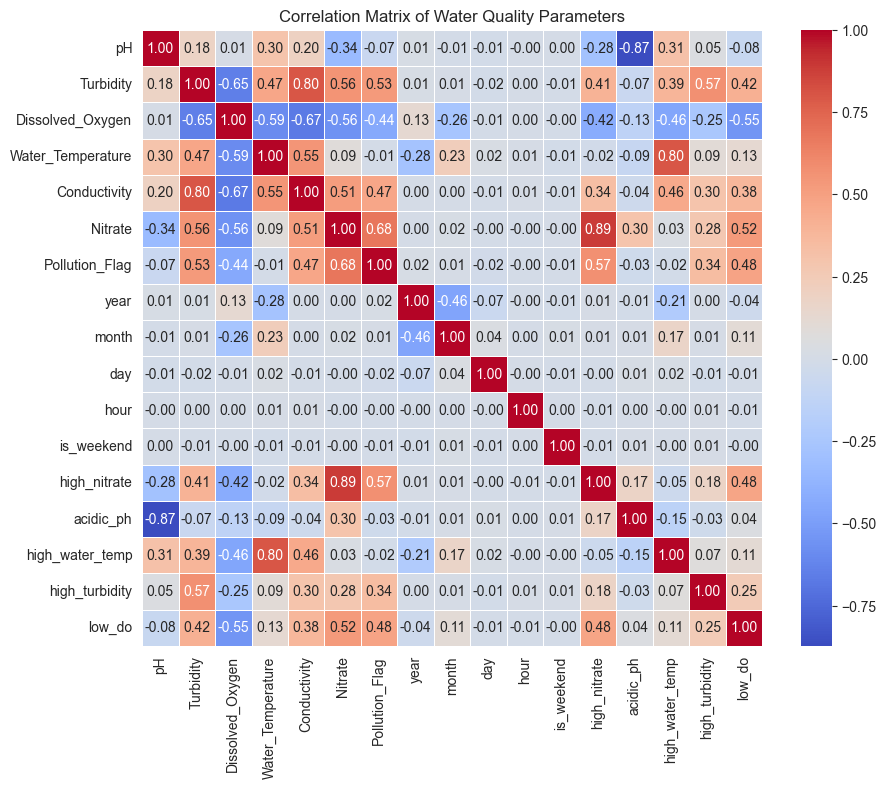

In [13]:
# Remove non-numeric columns and WQI before computing the correlation matrix
df_numeric = df.select_dtypes(include=['number']).drop(columns=['Factory_ID', 'Water_Quality_Index'], errors='ignore')

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Print correlation matrix
print("\nDataset Correlation Matrix (Updated Features):")
print(correlation_matrix)

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Water Quality Parameters")
plt.show()

In [16]:
# Save preprocessed dataset
df.to_csv('river_health_preprocessed.csv', index=False)

In [17]:
df_clean = pd.read_csv('river_health_preprocessed.csv')

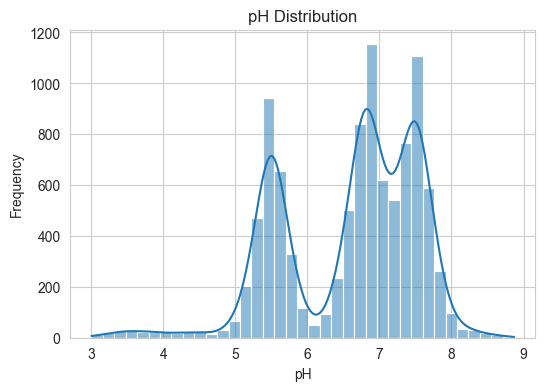

In [18]:
# Histogram for pH
plt.figure(figsize=(6, 4))
sns.histplot(df['pH'].dropna(), kde=True)
plt.title('pH Distribution')
plt.xlabel('pH')
plt.ylabel('Frequency')
plt.show()

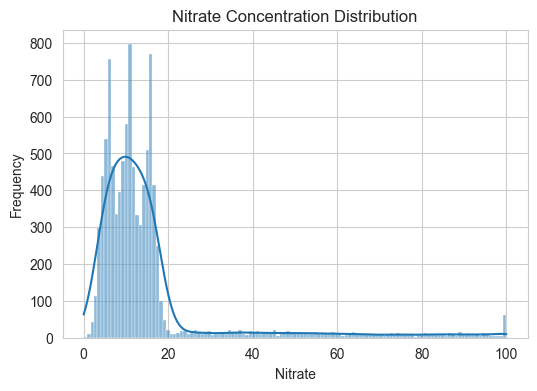

In [19]:
# Histogram for Nitrate
plt.figure(figsize=(6, 4))
sns.histplot(df_clean['Nitrate'].dropna(), kde=True)
plt.title('Nitrate Concentration Distribution')
plt.xlabel('Nitrate')
plt.ylabel('Frequency')
plt.show()

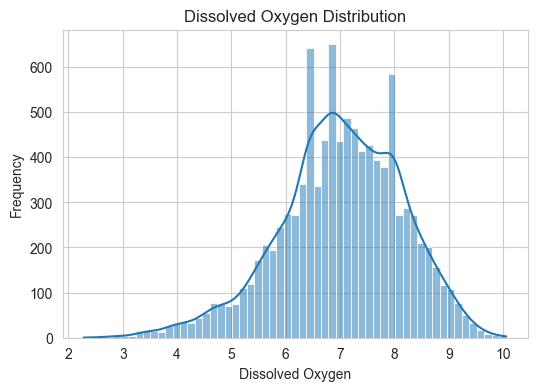

In [20]:
# Histogram for Dissolved Oxygen
plt.figure(figsize=(6, 4))
sns.histplot(df_clean['Dissolved_Oxygen'].dropna(), kde=True)
plt.title('Dissolved Oxygen Distribution')
plt.xlabel('Dissolved Oxygen')
plt.ylabel('Frequency')
plt.show()

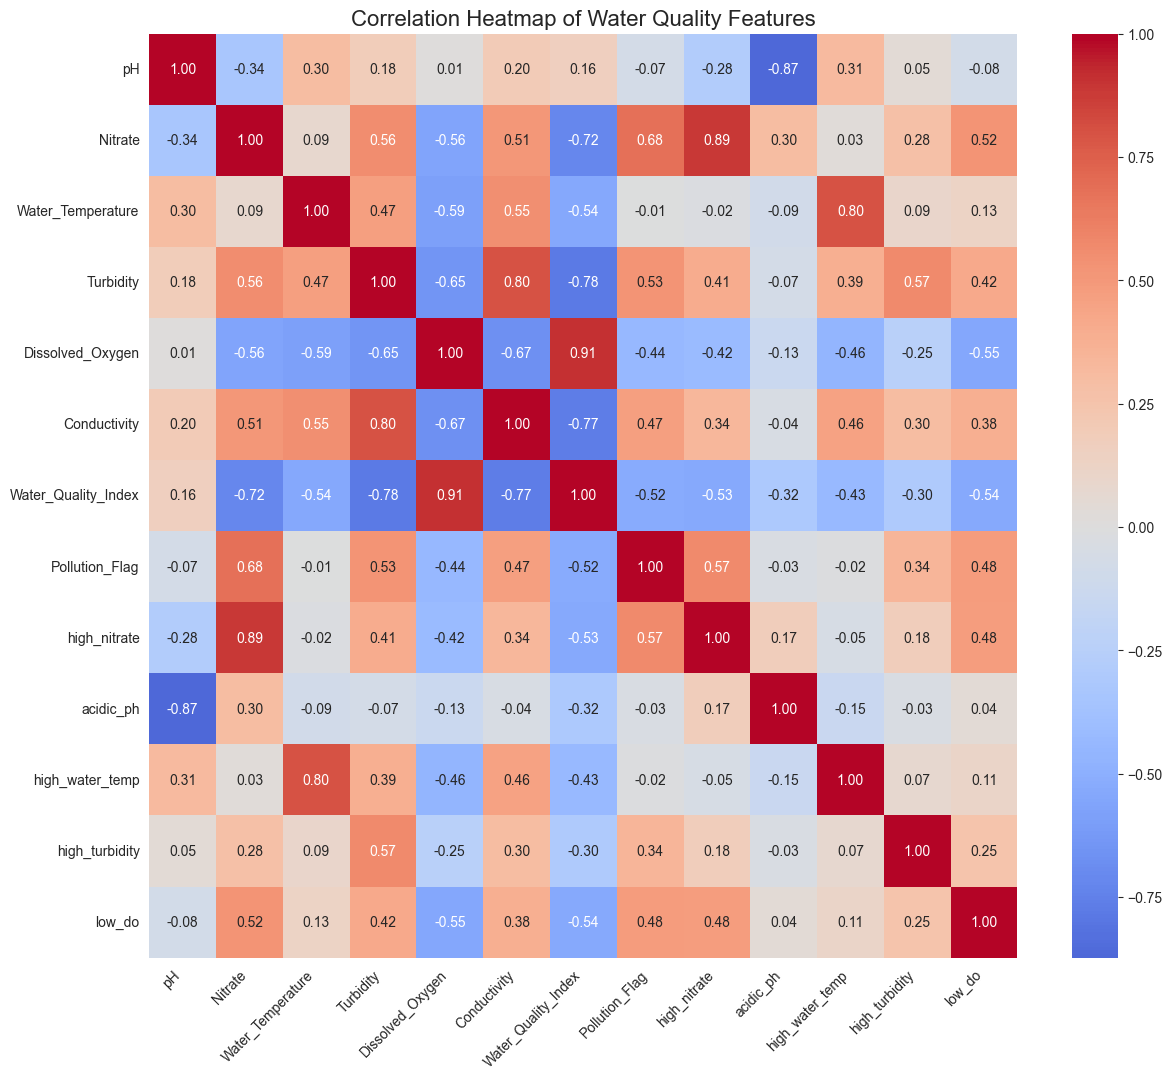

In [34]:
def plot_correlation_heatmap(df_clean):
    cols = [
        "pH", "Nitrate", "Water_Temperature", "Turbidity", "Dissolved_Oxygen",
        "Conductivity", "Water_Quality_Index", "Pollution_Flag",
        "high_nitrate", "acidic_ph", "high_water_temp",
        "high_turbidity", "low_do", "Industry_Type_Encoded"
    ]

    cols = [c for c in cols if c in df_clean.columns]
    corr = df_clean[cols].corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("Correlation Heatmap of Water Quality Features", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()
plot_correlation_heatmap(df_clean)

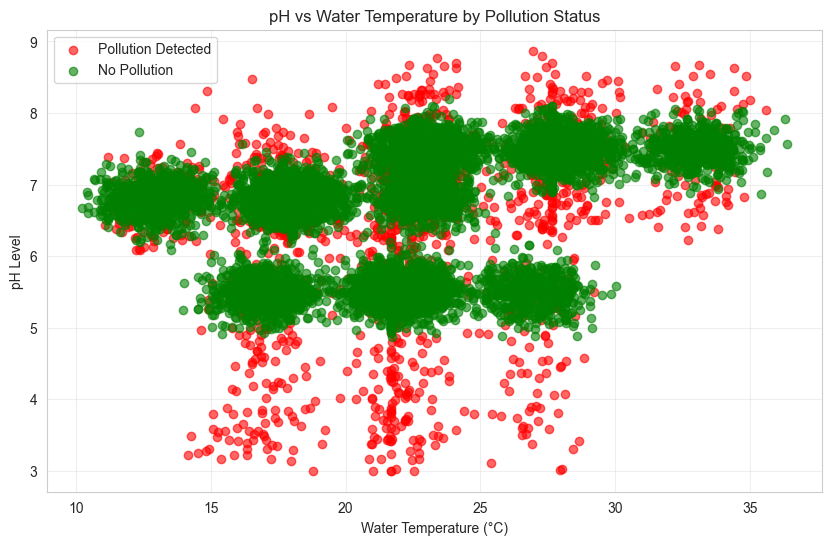

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(df_clean.Water_Temperature[df_clean.Pollution_Flag == 1],
           df_clean.pH[df_clean.Pollution_Flag == 1],
           color='red',
           alpha=0.6,
           label='Pollution Detected')

plt.scatter(df_clean.Water_Temperature[df_clean.Pollution_Flag == 0],
           df_clean.pH[df_clean.Pollution_Flag == 0],
           color='green',
           alpha=0.6,
           label='No Pollution')

plt.title("pH vs Water Temperature by Pollution Status")
plt.xlabel("Water Temperature (°C)")
plt.ylabel("pH Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
# Encode categorical variable 'factory_industry'
encoder = LabelEncoder()
df_clean["Industry_Type"] = encoder.fit_transform(df_clean["Industry_Type"])

In [25]:
# Select features and target
X = df_clean[["Industry_Type", "pH", "Nitrate", "Water_Temperature", "Turbidity", "Dissolved_Oxygen", "Conductivity"]]
y = df_clean["Pollution_Flag"]

In [26]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [27]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True)
}

In [36]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

input_shape = X_train.shape[1]

def create_mlp_model(input_dim):
    model = keras.Sequential([

        keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

# Create the MLP model instance
mlp_model = create_mlp_model(input_shape)

C:\Users\badve\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)


history = mlp_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=0
)

In [38]:
#Evaluate the Model
y_pred_prob_mlp = mlp_model.predict(X_test, verbose=0)
y_pred_mlp = (y_pred_prob_mlp > 0.5).astype("int32")
y_test_flat = y_test.values.flatten()
y_pred_mlp_flat = y_pred_mlp.flatten()
conf_matrix_mlp = confusion_matrix(y_test_flat, y_pred_mlp_flat)
class_report_mlp = classification_report(y_test_flat, y_pred_mlp_flat, target_names=['Not Polluted (0)', 'Polluted (1)'])
print("\nConfusion Matrix (MLP):\n", conf_matrix_mlp)
print("\nClassification Report (MLP):\n", class_report_mlp)
plt.figure(figsize=(12, 5))


Confusion Matrix (MLP):
 [[1683    3]
 [  23  291]]

Classification Report (MLP):
                   precision    recall  f1-score   support

Not Polluted (0)       0.99      1.00      0.99      1686
    Polluted (1)       0.99      0.93      0.96       314

        accuracy                           0.99      2000
       macro avg       0.99      0.96      0.97      2000
    weighted avg       0.99      0.99      0.99      2000



<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

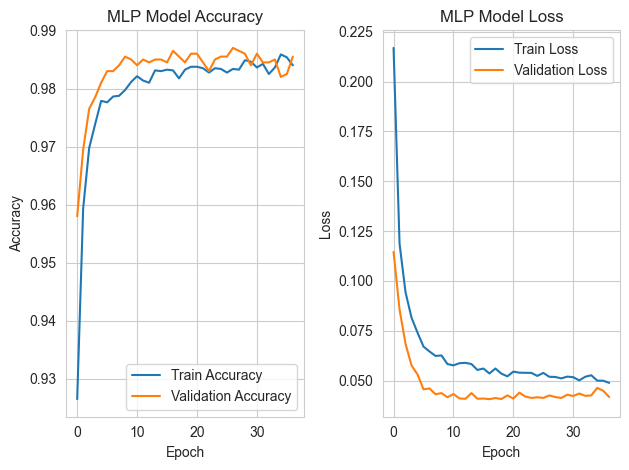

In [39]:
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


X_train_seq = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
lstm_model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, return_sequences=True, recurrent_dropout=0.3),
    Dropout(0.3),
    LSTM(32, recurrent_dropout=0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

In [41]:
# Evaluate the LSTM model
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_seq, y_test, verbose=0)
print(f"\nLSTM Model Accuracy: {accuracy_lstm:.2f}")

y_pred_prob_lstm = lstm_model.predict(X_test_seq, verbose=0)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype("int32")

conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
class_report_lstm = classification_report(y_test, y_pred_lstm)

print("\nConfusion Matrix (LSTM):\n", conf_matrix_lstm)
print("\nClassification Report (LSTM):\n", class_report_lstm)


LSTM Model Accuracy: 0.98

Confusion Matrix (LSTM):
 [[1680    6]
 [  26  288]]

Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1686
           1       0.98      0.92      0.95       314

    accuracy                           0.98      2000
   macro avg       0.98      0.96      0.97      2000
weighted avg       0.98      0.98      0.98      2000



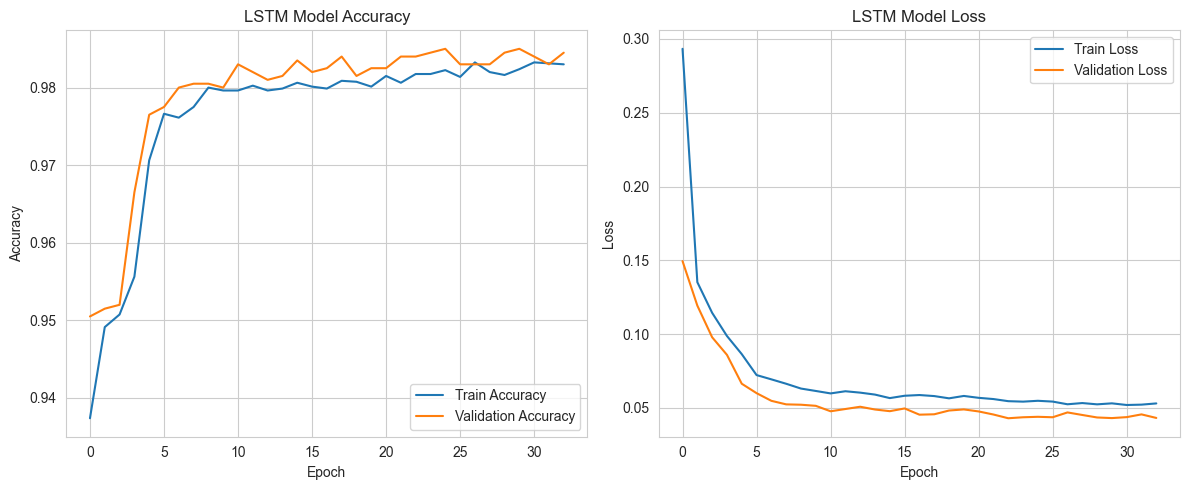

In [44]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize result dictionary
evaluation_results = {}
best_model = None
best_accuracy = 0
best_model_name = ""

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    evaluation_results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

In [48]:
# Extract metrics for the LSTM model
class_report_lstm_lines = class_report_lstm.split('\n')
lstm_metrics = {}
for line in class_report_lstm_lines:
    if 'weighted avg' in line:
        parts = line.split()
        lstm_metrics['Precision'] = float(parts[2]) * 100
        lstm_metrics['Recall'] = float(parts[3]) * 100
        lstm_metrics['F1 Score'] = float(parts[4]) * 100

# Get accuracy from the LSTM model evaluation
lstm_metrics['Accuracy'] = accuracy_lstm * 100

# Add LSTM results to evaluation_results dictionary
evaluation_results['LSTM'] = lstm_metrics

In [49]:
# Extract metrics for the MLP model from the classification report
class_report_mlp_lines = class_report_mlp.split('\n')
mlp_metrics = {}
for line in class_report_mlp_lines:
    if 'weighted avg' in line:
        parts = line.split()
        mlp_metrics['Precision'] = float(parts[2]) * 100
        mlp_metrics['Recall'] = float(parts[3]) * 100
        mlp_metrics['F1 Score'] = float(parts[4]) * 100

# Get accuracy from the MLP model evaluation (assuming it's available from the history object or model.evaluate)
# Use the best validation accuracy from the training history
best_val_accuracy = max(history.history['val_accuracy'])
mlp_metrics['Accuracy'] = best_val_accuracy * 100

# Add MLP results to evaluation_results dictionary
evaluation_results['MLP'] = mlp_metrics

In [50]:
# Extract metrics for plotting
model_names = list(evaluation_results.keys())
accuracies = [evaluation_results[model]['Accuracy'] for model in model_names]
precisions = [evaluation_results[model]['Precision'] for model in model_names]
recalls = [evaluation_results[model]['Recall'] for model in model_names]
f1_scores = [evaluation_results[model]['F1 Score'] for model in model_names]


# Print results for all models
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, val in metrics.items():
        print(f"  {metric}: {val:.2f}%")


Model: Logistic Regression
  Accuracy: 95.15%
  Precision: 95.36%
  Recall: 95.15%
  F1 Score: 94.79%

Model: Decision Tree
  Accuracy: 97.35%
  Precision: 97.36%
  Recall: 97.35%
  F1 Score: 97.36%

Model: Random Forest
  Accuracy: 98.40%
  Precision: 98.39%
  Recall: 98.40%
  F1 Score: 98.38%

Model: SVM
  Accuracy: 98.10%
  Precision: 98.13%
  Recall: 98.10%
  F1 Score: 98.05%

Model: LSTM
  Precision: 98.00%
  Recall: 98.00%
  F1 Score: 98.00%
  Accuracy: 98.40%

Model: MLP
  Precision: 99.00%
  Recall: 99.00%
  F1 Score: 99.00%
  Accuracy: 98.70%


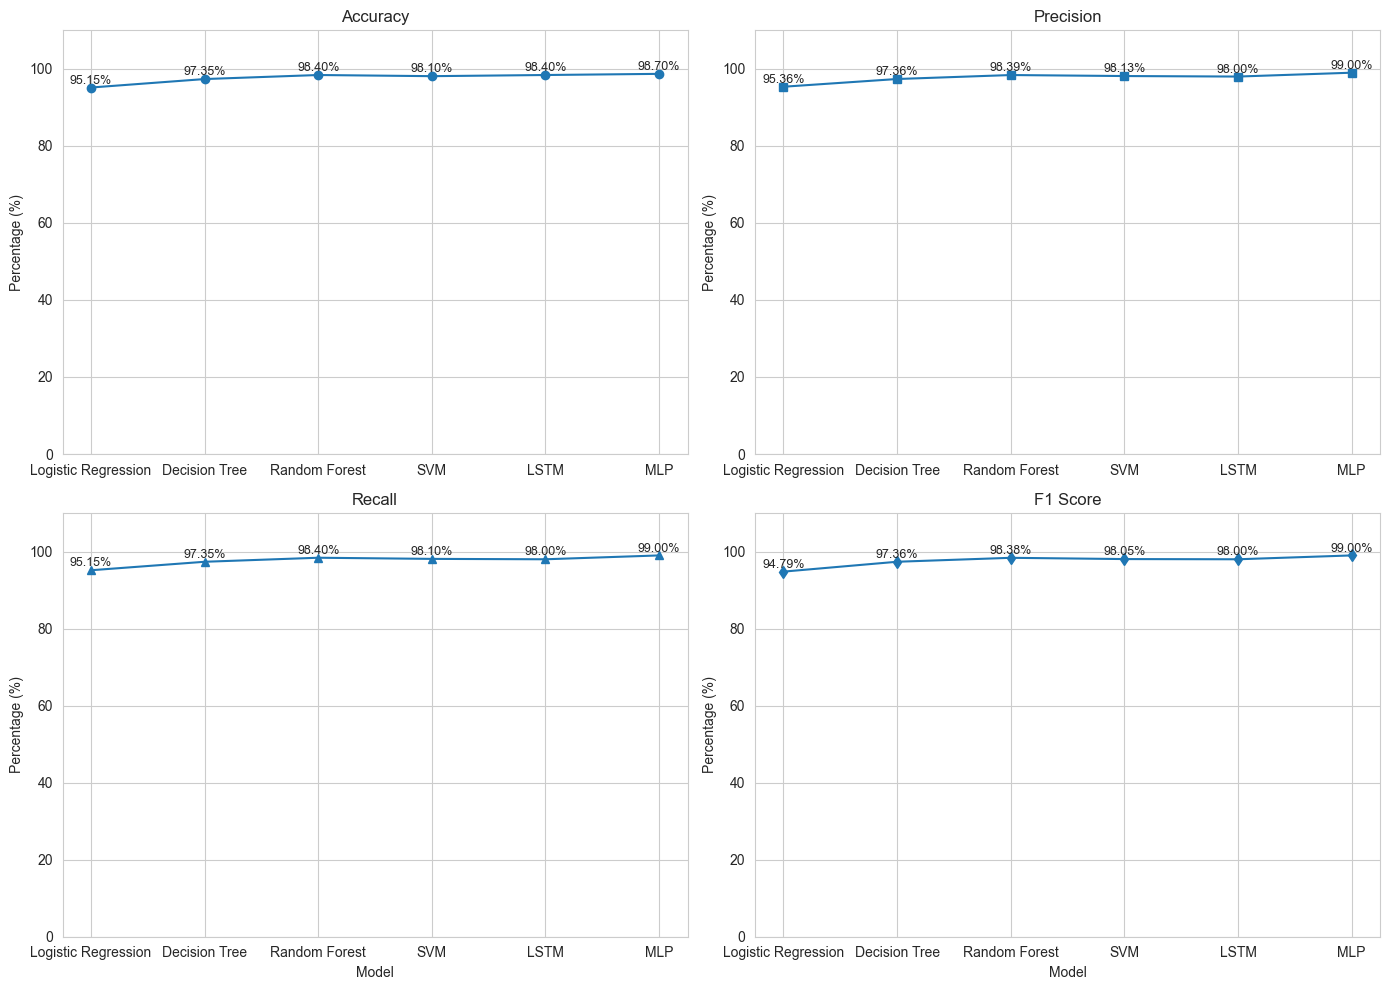

In [52]:
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(model_names, accuracies, marker="o")
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", fontsize=9)
plt.title("Accuracy")
plt.ylabel("Percentage (%)")
plt.ylim(0, 110)
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(model_names, precisions, marker="s")
for i, v in enumerate(precisions):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", fontsize=9)
plt.title("Precision")
plt.ylabel("Percentage (%)")
plt.ylim(0, 110)
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(model_names, recalls, marker="^")
for i, v in enumerate(recalls):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", fontsize=9)
plt.title("Recall")
plt.xlabel("Model")
plt.ylabel("Percentage (%)")
plt.ylim(0, 110)
plt.grid(True)

# F1 Score
plt.subplot(2, 2, 4)
plt.plot(model_names, f1_scores, marker="d")
for i, v in enumerate(f1_scores):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", fontsize=9)
plt.title("F1 Score")
plt.xlabel("Model")
plt.ylabel("Percentage (%)")
plt.ylim(0, 110)
plt.grid(True)

plt.tight_layout()
plt.show()


In [53]:
# Find the best model based on accuracy
best_accuracy = 0
best_model_name = ""

for model, metrics in evaluation_results.items():
    if metrics['Accuracy'] > best_accuracy:
        best_accuracy = metrics['Accuracy']
        best_model_name = model

print(f"The best performing model is: {best_model_name}")
print(f"Metrics for {best_model_name}:")
for metric, val in evaluation_results[best_model_name].items():
    print(f"  {metric}: {val:.2f}%")

The best performing model is: MLP
Metrics for MLP:
  Precision: 99.00%
  Recall: 99.00%
  F1 Score: 99.00%
  Accuracy: 98.70%


In [54]:
# Evaluate best model
y_pred_best = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probability scores for ROC curve
conf_matrix = confusion_matrix(y_test, y_pred_best)
class_report = classification_report(y_test, y_pred_best)

In [55]:
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[1679    7]
 [  25  289]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1686
           1       0.98      0.92      0.95       314

    accuracy                           0.98      2000
   macro avg       0.98      0.96      0.97      2000
weighted avg       0.98      0.98      0.98      2000



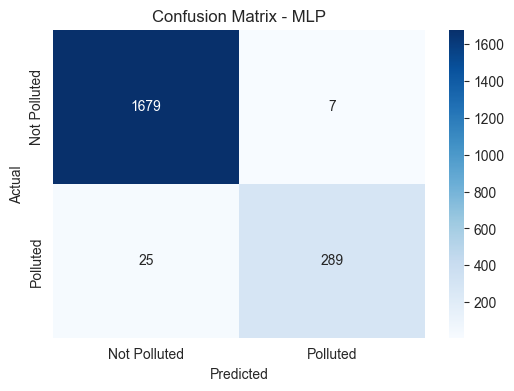

In [56]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Polluted", "Polluted"], yticklabels=["Not Polluted", "Polluted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

In [57]:
# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

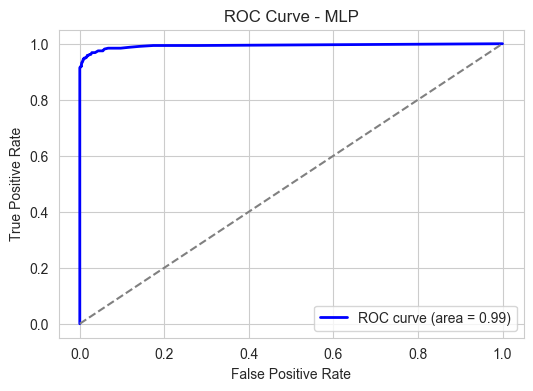

In [58]:
# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model_name}")
plt.legend(loc="lower right")
plt.show()

In [59]:
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']